While ARIMA excepts the parameters (p,d,q), SARIMAX accepts an additional set of parameters (P,D,Q)m that specifically describe the seasonal components of the model.

The 'X' in SARIMAX means that the function also supports *exogenous regressor variables*.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

Let's load the data and make it in timeseries format

**Step 1 : Loading the data**

In [14]:
df = pd.read_csv(r'C:\Users\nevishwakarma\Documents\Datasets\Data_Udemy\co2_mm_mlo.csv', parse_dates=True)
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [15]:
df['Date'] = pd.to_datetime({'year':df['year'], 'month' : df['month'], 'day' : 1})

In [16]:
df.set_index('Date')
df.index.freq = 'MS'

<AxesSubplot:>

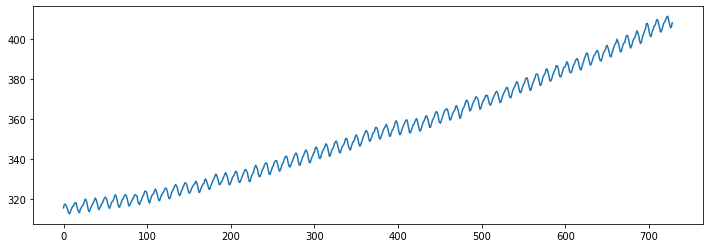

In [17]:
df['interpolated'].plot(figsize=(12,4))

From the plot, we can see that the data has an upward trend and seasonality. Let's check this quantitatively.

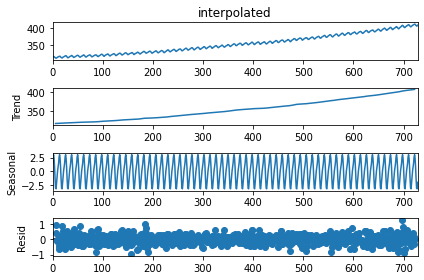

In [22]:
results = seasonal_decompose(df['interpolated'], model='add',period=12)
results.plot();

**When the seasonal decompose shows a heavy residual values, it means that the neither the seasonal nor the trend components are able to explain the timeseries behaviour and it may be some outside factor casuing the noice there, and it will be hard for any model to do proper forcasting.**

<AxesSubplot:>

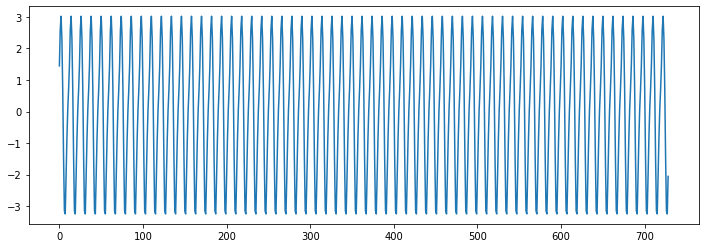

In [23]:
results.seasonal.plot(figsize=(12,4))

The seasonal cycle repeats after every 12 months.

Let's now see what walues pf hyperparams does <tt>auto_arima</tt> suggests.

**Step 2 : Calculating (p,d,q) and (P,D,Q,m)**

In [24]:
auto_arima(df['interpolated'], seasonal=True, m=12).summary() # The seasonal cycle repeats after every 12 months. So m =12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.254
Date:                            Thu, 30 Dec 2021   AIC                            424.508
Time:                                    15:14:55   BIC                            452.049
Sample:                                         0   HQIC                           435.135
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3518      0.084      4.210      0.000       0.188       0.516
ar.L2          0.0866      0.055      1.566      0.117      -0.022       0.195
ma.L1         -0.7049      0.088     -7.969      0.000      -0.878      -0.532
ar.S.L12       0.9996      0.000   2845.277      0.000       0.999       1.000
ma.S.L12      -0.8671      0.021    -40.669      0.000      -0.909      -0.825
sigma2         0.0955      0.005     20.931      0.000       0.087       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 4.46
Prob(Q):                              0.75   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Step 3 : Train - Test Split**

In [25]:
len(df)

729

In [26]:
train = df.iloc[:717]
test = df.iloc[717:]

**Step 4 : Modelling**

In [27]:
model = SARIMAX(train['interpolated'], order=(2, 1, 1), seasonal_order=(1, 0, 1, 12))
results = model.fit()

In [28]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.882
Date:                            Thu, 30 Dec 2021   AIC                            415.765
Time:                                    15:23:56   BIC                            443.207
Sample:                                         0   HQIC                           426.362
                                            - 717                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3461      0.100      3.460      0.001       0.150       0.542
ar.L2          0.0828      0.050      1.649      0.099      -0.016       0.181
ma.L1         -0.7001      0.096     -7.263      0.000      -0.889      -0.511
ar.S.L12       0.9996      0.000   2790.613      0.000       0.999       1.000
ma.S.L12      -0.8654      0.023    -37.975      0.000      -0.910      -0.821
sigma2         0.0954      0.005     20.342      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.67
Prob(Q):                              0.80   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Step 5 : Prediction for Testing**

In [30]:
start = len(train)
end = start + len(test) - 1

In [31]:
predictions = results.predict(start,end,typ='levels')

<AxesSubplot:>

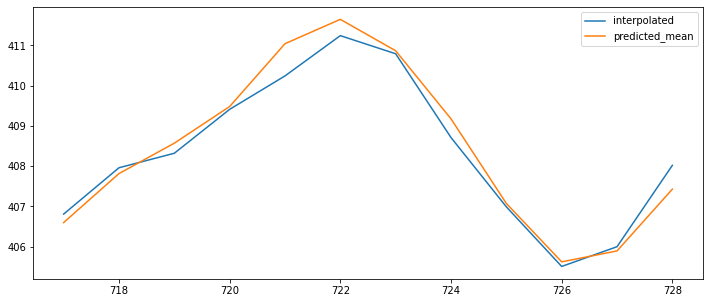

In [32]:
test['interpolated'].plot(figsize=(12,5), legend=True)
predictions.plot(figsize=(12,5), legend=True)

**Step 6 : Model Evaluation**

In [38]:
from statsmodels.tools.eval_measures import rmse

In [40]:
error = rmse(test['interpolated'], predictions)
error

0.3578772808956247

In [41]:
test['interpolated'].mean()

408.3333333333333

In [42]:
predictions.mean()

408.4341369548518

**Step 7 : Forecasting**

In [33]:
model = SARIMAX(df['interpolated'], order=(2, 1, 1), seasonal_order=(1, 0, 1, 12))
results = model.fit()

C:\Users\nevishwakarma\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
forecasts = results.predict(len(df),len(df) + 12 ,typ='levels').rename("Forecasted")

<AxesSubplot:>

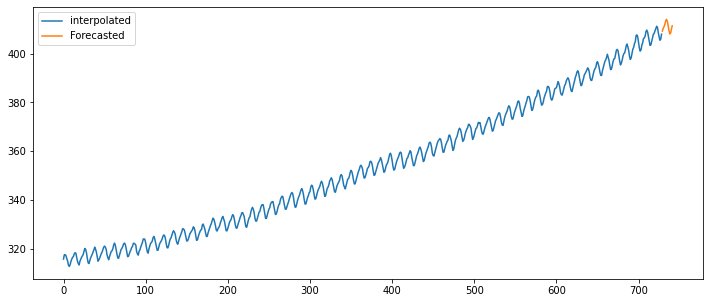

In [52]:
df['interpolated'].plot(figsize=(12,5), legend=True)
forecasts.plot(figsize=(12,5), legend=True)